In [2]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

In [3]:
#IN df_to_shift: the dataframe we want to shift
#IN ndays: how many days we want to shift, ndays>0 shift forward, ndays<0 shift backward
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col):
    df_shifted = df_to_shift.set_index(pd.to_datetime(df_to_shift['day'])).drop(columns=['day'])
    df_shifted=df_shifted.resample('24H',origin='start').asfreq()
    #process some daily changes in FRP
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    inds = df_shifted.index.isin(df_to_shift['day'])
    return df_shifted[inds].reset_index()

In [4]:
def plot_correlations(df_all, fig_title,correlation_type):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=(25,25))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':28})
    plt.title(fig_title, fontsize=20)
    plt.show()

In [5]:
def plot_log(y_test, y_pred, model_name, low, high):
    plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred)
    plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
    plt.title(model_name,  fontsize=32)
    plt.xlabel('True FRP Values (MW)', fontsize=24)
    plt.ylabel('Predicted FRP Values (MW)', fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.xlim([low, high])
    plt.ylim([low, high])
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

In [6]:
# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.mean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.median(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

In [7]:
def REC(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)/y_test)*100
    thresholds = np.linspace(0,300, 61) #5% increments

    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*5)) #left hand approximation, assuming bins are 5 wide

In [8]:
def scatter_plot(df_plot,x_plot,y_plot,point_hue, point_style, point_size, point_size_range,plot_title):
    fig,ax=plt.subplots(figsize=(10,10))
    sns.scatterplot(data =df_plot, x=x_plot,y=y_plot,hue=point_hue,
                    style=point_style,size=point_size,sizes=point_size_range,ax=ax,cmap='jet')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(plot_title)
    plt.show()

# Put all of the cases together

In [9]:
def combine_fires(inci_name_list):
    #most up to date version as of 11/3, DOESN'T HAVE FIRELINE yet
    hrrr_ws_all = pd.DataFrame()
    names_all = pd.DataFrame()
    resources_all = pd.DataFrame()
    fuel_loading_all = pd.DataFrame()
    days_all = pd.DataFrame()
    rave_all = pd.DataFrame()
    fwi_all = pd.DataFrame()
    smops_all = pd.DataFrame()
    pws_all = pd.DataFrame()
    ncar_all = pd.DataFrame()
    
    path_features='/data2/lthapa/ML_daily/fire_features/'
    path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
    suffix_poly = 'Z_day_start.geojson'
    start_time=12
    for ii in range(len(inci_name_list)):
        file_prefix = inci_name_list[ii].lower().replace(' ', '_')
        print(file_prefix)

        #load in the data
        rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
        hrrr_ws = pd.read_csv(path_features+file_prefix+'_Daily_HRRR_ws_'+str(start_time)+'Z_day_start.csv')
        resources = pd.read_csv(path_features+file_prefix+'_Daily_Resources_'+str(start_time)+'Z_day_start.csv')
        fuels = pd.read_csv(path_features+file_prefix+'_Daily_COARSE990_FUEL_FWI_'+str(start_time)+'Z_day_start.csv')
        #slopes = pd.read_csv(path_features+file_prefix+'_Daily_COARSE990_FUEL_FWI_'+str(start_time)+'Z_day_start.csv')
        fwi = pd.read_csv(path_features+file_prefix+'_Daily_IMERG_FWI_NoAve_'+str(start_time)+'Z_day_start.csv')
        smops = pd.read_csv(path_features+file_prefix+'_Daily_SMOPS_'+str(start_time)+'Z_day_start.csv')
        pws = pd.read_csv(path_features+file_prefix+'_Daily_PWS_'+str(start_time)+'Z_day_start.csv')
        ncar = pd.read_csv(path_features+file_prefix+'_Daily_NCAR_Moisture_'+str(start_time)+'Z_day_start.csv')
        
        #derive some additional stuff
        names = pd.DataFrame({'name':[inci_name_list[ii]]*len(rave)})
        days = pd.DataFrame({'day':np.zeros(len(rave))})
        days['day'] = rave['day'].values

        #do the shift
        rave_shifted = shift_ndays(rave, 1, ['Mean_FRP'], ['Yesterday_FRP'])
        hrrr_ws_shifted = shift_ndays(hrrr_ws, 1, ['hd0w0','hd1w0','hwp'],['Yesterday_hd0w0', 'Yesterday_hd1w0','Yesterday_hwp'])
        fwi_shifted = shift_ndays(fwi, 1,['IMERG.FINAL.v6_FWI'],['Yesterday_fwi'])
        resources_shifted = shift_ndays(resources,1,['percent_contained'],['Yesterday_percent_contained'])
        ncar_shifted = shift_ndays(ncar, 1, ['FMCG2D','FMCGLH2D'],['Yesterday_FMCG2D','Yesterday_FMCGLH2D'])

        if inci_name_list[ii] =='HOLIDAY FARM':#holiday farm is missing the first day in reosurces, drop it
            rave_shifted = rave_shifted.drop(labels=0,axis=0).reset_index(drop=True)
            hrrr_ws_shifted = hrrr_ws_shifted.drop(labels=0,axis=0).reset_index(drop=True)
            names = names.drop(labels=0,axis=0).reset_index(drop=True)
            fuels = fuels.drop(labels=0,axis=0).reset_index(drop=True)
            days = days.drop(labels=0,axis=0).reset_index(drop=True)
            fwi_shifted = fwi_shifted.drop(labels=0,axis=0).reset_index(drop=True)
            smops = smops.drop(labels=0,axis=0).reset_index(drop=True)
            pws = pws.drop(labels=0,axis=0).reset_index(drop=True)
            ncar_shifted=ncar_shifted.drop(labels=0, axis=0).reset_index(drop=True)

            
        inds_active = np.where(rave_shifted['Mean_FRP']>10)[0] #this is the threshold I used at NOAA


        hrrr_ws_all = pd.concat([hrrr_ws_all, hrrr_ws_shifted.iloc[inds_active]],axis=0)
        names_all = pd.concat([names_all, names.iloc[inds_active]],axis=0)
        resources_all = pd.concat([resources_all, resources_shifted.iloc[inds_active]],axis=0)
        fuel_loading_all = pd.concat([fuel_loading_all, fuels.iloc[inds_active]],axis=0)
        days_all = pd.concat([days_all, days.iloc[inds_active]],axis=0)
        fwi_all = pd.concat([fwi_all, fwi_shifted])
        rave_all = pd.concat([rave_all, rave_shifted.iloc[inds_active]],axis=0)
        smops_all = pd.concat([smops_all,smops.iloc[inds_active]],axis=0)
        pws_all = pd.concat([pws_all,pws.iloc[inds_active]],axis=0)
        ncar_all = pd.concat([ncar_all, ncar_shifted.iloc[inds_active]],axis=0)
        
    #put the features together
    features_list = [days_all[['day']].reset_index(drop=True),
                names_all[['name']].reset_index(drop=True),
                hrrr_ws_all[['hd0w0','hd1w0','hwp','Yesterday_hd0w0','Yesterday_hwp']].reset_index(drop=True),
                resources_all[['Yesterday_percent_contained']].reset_index(drop=True),
                fuel_loading_all[['Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N']].reset_index(drop=True),
                fwi_all[['IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC',
                         'IMERG.FINAL.v6_FWI','Yesterday_fwi']].reset_index(drop=True),
                smops_all[['Blended_SM']].reset_index(drop=True),
                pws_all[['PWS']].reset_index(drop=True),
                rave_all[['Mean_FRP','Yesterday_FRP']].reset_index(drop=True),
                ncar_all[['FMCG2D','FMCGLH2D','Yesterday_FMCG2D','Yesterday_FMCGLH2D']].reset_index(drop=True)
                    ]
    features = pd.concat(features_list,axis=1)
    
    return features

In [12]:
inci_train = ['BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH','EAST TROUBLESOME']
inci_test = ['AUGUST COMPLEX']

data_train= combine_fires(inci_train) #train on not august complex (250 points, 79% of days)
data_train['cont1_hd1w0'] = data_train['hd1w0']*(1-(data_train['Yesterday_percent_contained']/100))
data_train['cont1_hwp'] = data_train['hwp']*(1-(data_train['Yesterday_percent_contained']/100))
data_train['1_minus_percent_cont'] = (1-(data_train['Yesterday_percent_contained']/100))

data_test = combine_fires(inci_test) #test on august complex (69 points, 21% of days)
data_test['cont1_hd1w0'] = data_test['hd1w0']*(1-(data_test['Yesterday_percent_contained']/100))
data_test['cont1_hwp'] = data_test['hwp']*(1-(data_test['Yesterday_percent_contained']/100))
data_test['1_minus_percent_cont'] = (1-(data_test['Yesterday_percent_contained']/100))
data_test['FRP1_rel_hd0w0'] = data_test['Yesterday_FRP']*data_test['hd0w0']/data_test['Yesterday_hd0w0']
data_test['FRP1_rel_hwp'] = data_test['Yesterday_FRP']*data_test['hwp']/data_test['Yesterday_hwp']
data_test['FRP1_rel_fwi'] = data_test['Yesterday_FRP']*data_test['IMERG.FINAL.v6_FWI']/data_test['Yesterday_fwi']


bobcat
dolan
holiday_farm
creek
lake
cameron_peak
pine_gulch
east_troublesome
august_complex


# use hd1w0 as the weather

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hd1w0','Yesterday_percent_contained','Extreme_N','Yesterday_FRP']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)
#print(linreg['linearregression'].coef_)


rf = make_pipeline(StandardScaler(), RandomForestRegressor()) #scaling is necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test[['day','name','hd1w0','Mean_FRP','Yesterday_FRP']]
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['RF_FRP'] = rf_frp_pred
print(labels_test)


In [ ]:
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hd1w0'],
                            figsize=(20,6),style='o-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP','Yesterday_FRP'],secondary_y=True,
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

In [ ]:
print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


plot_correlations(labels_test[['hd1w0','Linreg_FRP','RF_FRP','Yesterday_FRP','Mean_FRP']], 'August Complex','pearson')

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean


plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.4, label = 'Linear Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.4, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()


#REC CURVES
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)

plt.figure(figsize=(10,10))
plt.plot(thresh_LR, accuracies_LR)
plt.plot(thresh_RF, accuracies_RF)
plt.plot(thresholds_persistence, accuracy_persistence)
plt.legend(['Linear Regression', 'Random Forest Regression','Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

#scatter plots
low = 1
high = 1e6
plot_log(labels_test['Mean_FRP'].values, labels_test['RF_FRP'].values, 'Random Forest Regression', low, high)
plot_log(labels_test['Mean_FRP'].values, labels_test['Linreg_FRP'].values, 'Linear Regression', low, high)

# Use HWP as the weather

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['cont1_hwp','Yesterday_percent_contained','Extreme_N']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

rf = make_pipeline(StandardScaler(), RandomForestRegressor()) #scaling is necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test[['day','name','cont1_hwp','Mean_FRP','Yesterday_FRP']]
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['RF_FRP'] = rf_frp_pred
print(labels_test)


In [ ]:
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['cont1_hwp'],
                            figsize=(20,6),style='o-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP','Yesterday_FRP'],secondary_y=True,
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

In [ ]:
print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


plot_correlations(labels_test[['cont1_hwp','Linreg_FRP','RF_FRP','Yesterday_FRP','Mean_FRP']], 'August Complex','pearson')

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean


plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.4, label = 'Linear Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.4, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()


#REC CURVES
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)

plt.figure(figsize=(10,10))
plt.plot(thresh_LR, accuracies_LR)
plt.plot(thresh_RF, accuracies_RF)
plt.plot(thresholds_persistence, accuracy_persistence)
plt.legend(['Linear Regression', 'Random Forest Regression','Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

#scatter plots
low = 1
high = 1e6
plot_log(labels_test['Mean_FRP'].values, labels_test['RF_FRP'].values, 'Random Forest Regression', low, high)
plot_log(labels_test['Mean_FRP'].values, labels_test['Linreg_FRP'].values, 'Linear Regression', low, high)

# Use both, see if there is a better weather variable

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['cont1_hwp','cont1_hd1w0','Extreme_N']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

rf = make_pipeline(StandardScaler(), RandomForestRegressor()) #scaling is necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test[['day','name','cont1_hwp','cont1_hd1w0','Mean_FRP','Yesterday_FRP','Yesterday_percent_contained']]
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['RF_FRP'] = rf_frp_pred
print(labels_test)


In [ ]:
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['cont1_hwp','cont1_hd1w0'],
                            figsize=(20,6),style='o-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

In [ ]:
print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


plot_correlations(labels_test[['cont1_hwp','cont1_hd1w0','Linreg_FRP','RF_FRP','Yesterday_FRP','Mean_FRP']], 'August Complex','pearson')

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean


plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.4, label = 'Linear Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.4, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()


#REC CURVES
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)

plt.figure(figsize=(10,10))
plt.plot(thresh_LR, accuracies_LR)
plt.plot(thresh_RF, accuracies_RF)
plt.plot(thresholds_persistence, accuracy_persistence)
plt.legend(['Linear Regression', 'Random Forest Regression','Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

#scatter plots
low = 1
high = 1e6
plot_log(labels_test['Mean_FRP'].values, labels_test['RF_FRP'].values, 'Random Forest Regression', low, high)
plot_log(labels_test['Mean_FRP'].values, labels_test['Linreg_FRP'].values, 'Linear Regression', low, high)

In [ ]:
scatter_plot(labels_test,'Mean_FRP','RF_FRP','Yesterday_percent_contained', None, 'Yesterday_percent_contained', (20,200),'AC')

# Use non-contained weather variables

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','hd1w0','Yesterday_percent_contained']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
linreg.fit(features_train,labels_train)

##be smart about how we use RF
rf = RandomForestRegressor(oob_score=True)
rf.fit(features_train, labels_train)

#rf_scaled = make_pipeline(StandardScaler(), RandomForestRegressor()) #scaling doesn't make a huge difference
#rf_scaled.fit(features_train, labels_train)


labels_test = data_test[['day','name','hwp','hd1w0','Mean_FRP','Yesterday_FRP','Yesterday_percent_contained','Extreme_N']]
labels_test['RF_FRP'] = rf.predict(features_test)
labels_test['Linreg_FRP'] = linreg.predict(features_test)


print(labels_test)

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd1w0'],
                            figsize=(20,6),style='o-',ax=ax )
labels_test.plot(x='day', y=['RF_FRP','Linreg_FRP'],secondary_y=True,
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()


fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Extreme_N'],
                            figsize=(20,6),style='o-',ax=ax )
labels_test.plot(x='day', y=['RF_FRP','Linreg_FRP'],secondary_y=True,
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

In [ ]:
print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


plot_correlations(labels_test[['hwp','hd1w0','Linreg_FRP','RF_FRP','Yesterday_FRP','Mean_FRP']], 'August Complex','pearson')

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean


plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.4, label = 'Linear Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.4, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()


#REC CURVES
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)

plt.figure(figsize=(10,10))
plt.plot(thresh_LR, accuracies_LR)
plt.plot(thresh_RF, accuracies_RF)
plt.plot(thresholds_persistence, accuracy_persistence)
plt.legend(['Linear Regression', 'Random Forest Regression','Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

#scatter plots
low = 1
high = 1e6
plot_log(labels_test['Mean_FRP'].values, labels_test['RF_FRP'].values, 'Random Forest Regression', low, high)
plot_log(labels_test['Mean_FRP'].values, labels_test['Linreg_FRP'].values, 'Linear Regression', low, high)

In [ ]:
scatter_plot(labels_test,'Mean_FRP','RF_FRP','Yesterday_percent_contained', None, 'Yesterday_percent_contained', (20,200),'AC')

scatter_plot(labels_test,'Mean_FRP','RF_FRP','Extreme_N', None, 'Extreme_N', (20,200),'AC')

#  Features: HWP, HD1W0, Yesterday %cont, extreme fuel loading

Created 2/24, Updated 2/28 with non negative least squares


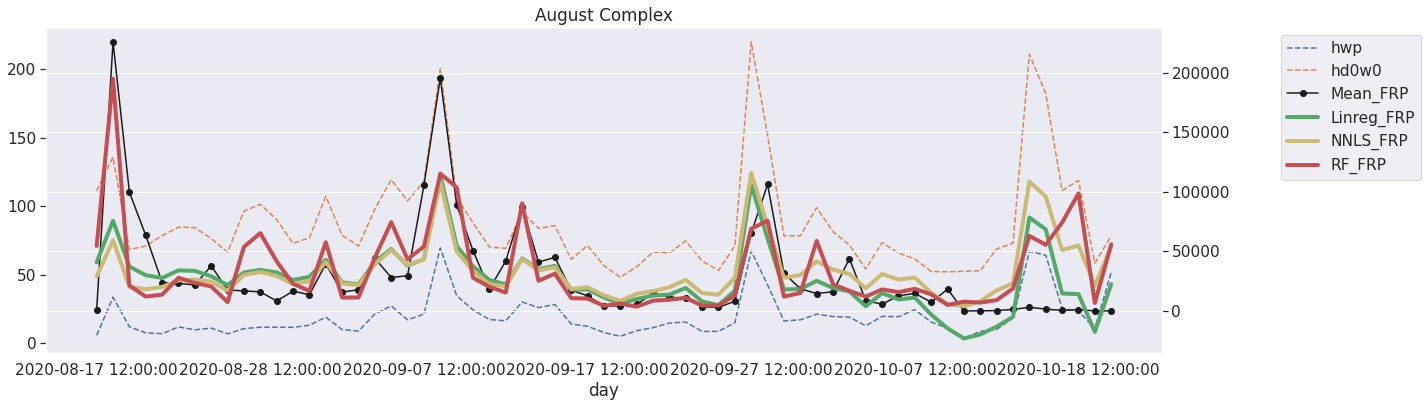

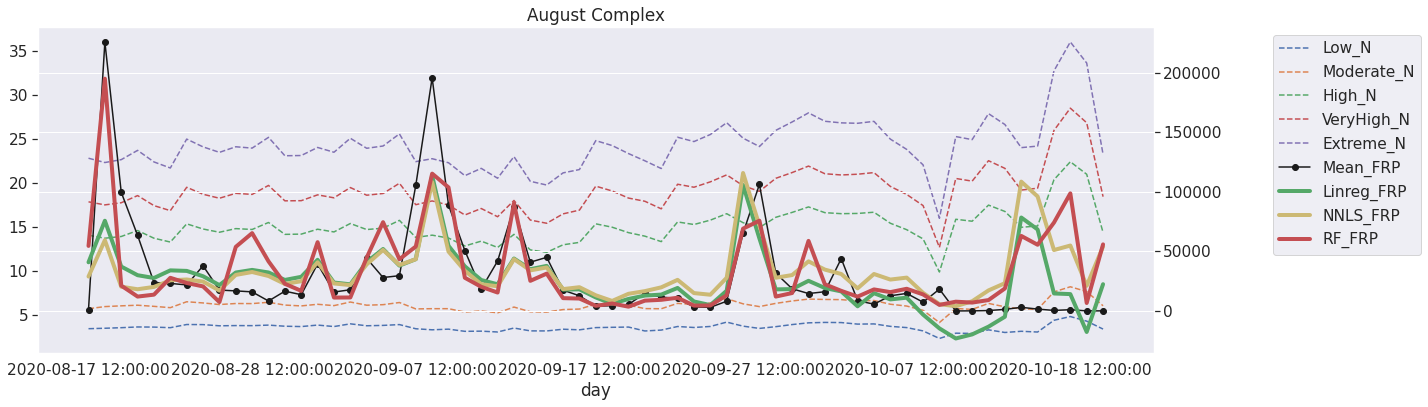

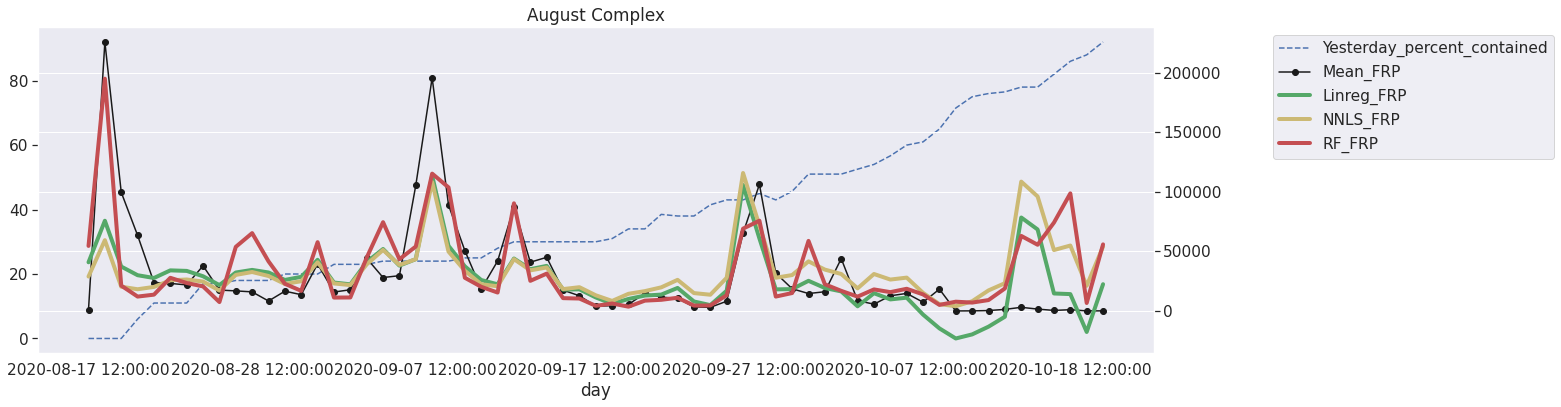

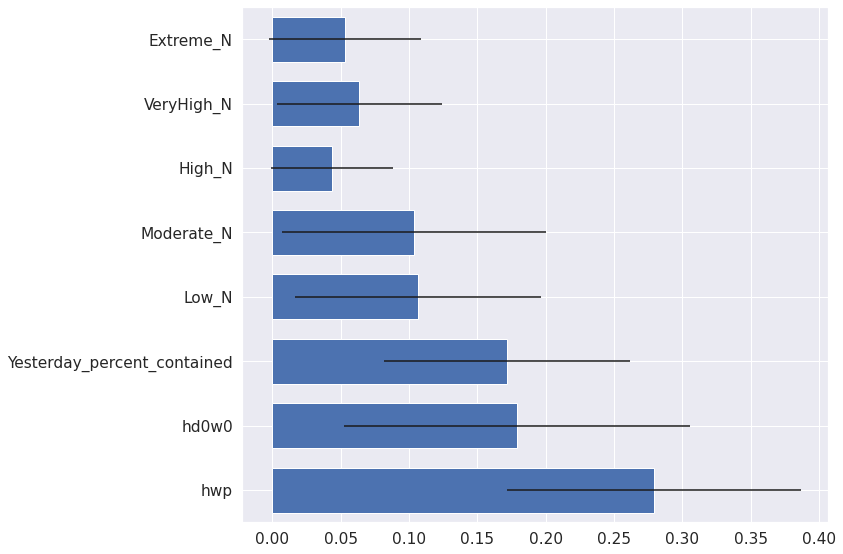

Feature: 0, Score: 14029.26419
Feature: 1, Score: 11365.34231
Feature: 2, Score: -15063.01613
Feature: 3, Score: 8317.00709
Feature: 4, Score: -5311.43014
Feature: 5, Score: 1883.98336
Feature: 6, Score: 108.20585
Feature: 7, Score: 2320.32899


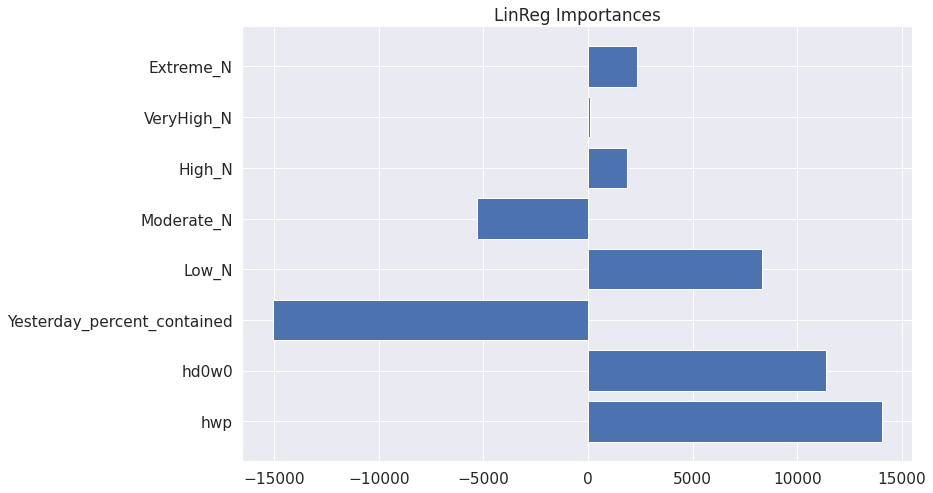

Feature: 0, Score: 10428.88084
Feature: 1, Score: 16131.31158
Feature: 2, Score: 0.00000
Feature: 3, Score: 9685.48208
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000


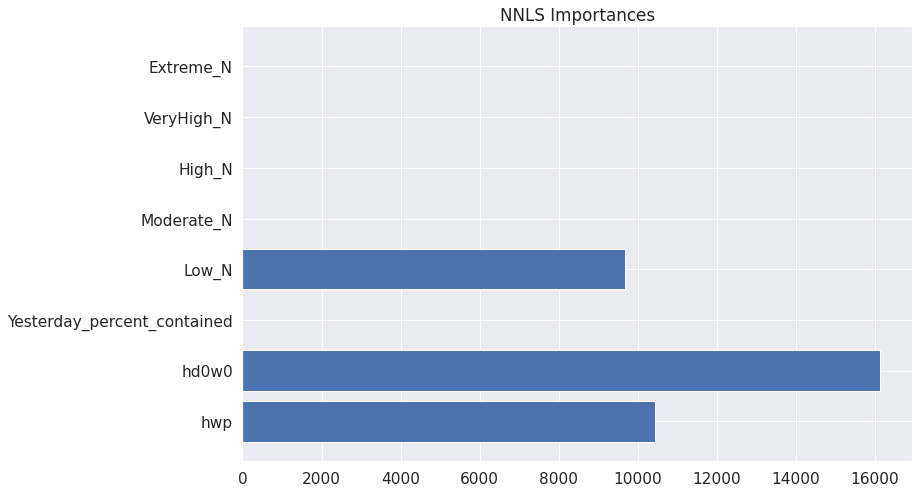

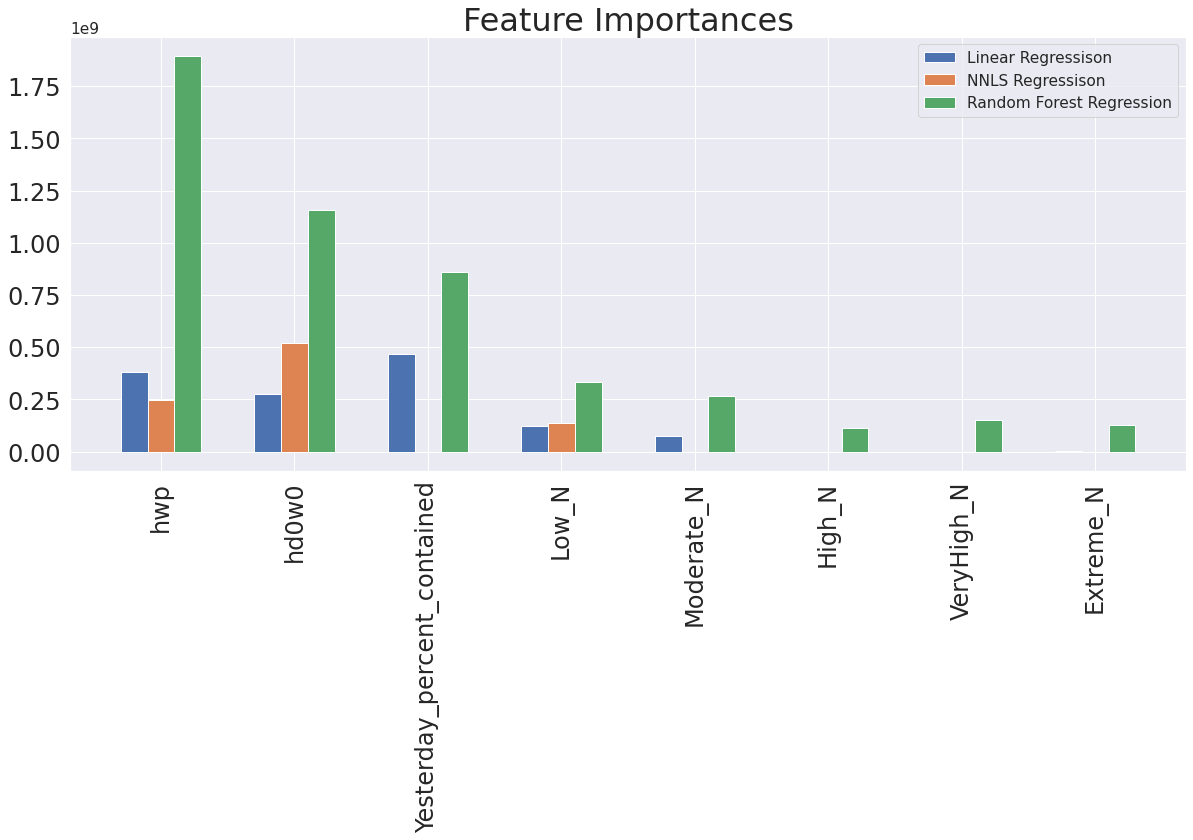

In [98]:
#this cell generates the ML predictions and evaluates them

#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','hd0w0','Yesterday_percent_contained','Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
#linreg = Ridge()
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

nnls = make_pipeline(StandardScaler(), Ridge(solver='lbfgs',positive=True)) #scaling is necessary
#linreg = Ridge()
nnls.fit(features_train,labels_train)
nnls_frp_pred = nnls.predict(features_test)

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['NNLS_FRP'] = nnls_frp_pred
labels_test['RF_FRP'] = rf_frp_pred


#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Yesterday_percent_contained'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()


tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_, height=0.7,xerr = std)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(features_test.columns)
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.show()

# get importance
importance = linreg.named_steps['ridge'].coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=np.arange(len(training_variables)),labels=training_variables)
plt.title('LinReg Importances')
plt.show()

importance = nnls.named_steps['ridge'].coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=np.arange(len(training_variables)),labels=training_variables)
plt.title('NNLS Importances')
plt.show()

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_pos_lr = permutation_importance(nnls, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.2, label = 'Linear Regressison')
plt.bar(X_axis, importance_pos_lr, 0.2, label = 'NNLS Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.2, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

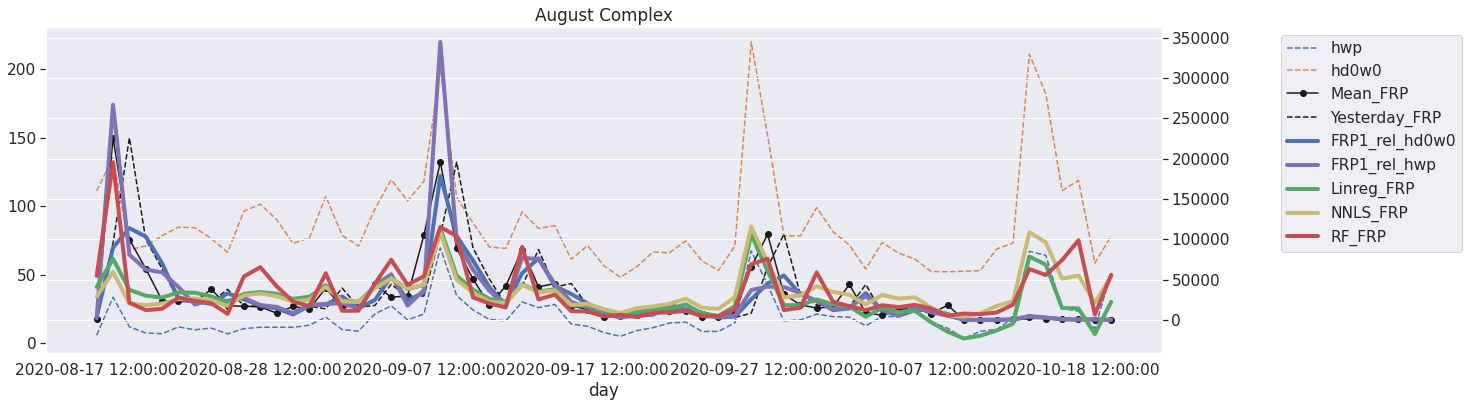

R2 scores:
Persistence score is: 0.23874435617129908
FRP1_rel_hd0w0 score is: 0.619983459770578
FRP1_rel_hwp score is: 0.6267629711513965
Linear regression score is: 0.4218905993457993
Non-Negative Linear regression score is: 0.18019970128350682
Random Forest regression score is: 0.4515274284966355 And the OOB score is: 0.6371911578069611

RMSE: 
Persistence score is: 36797.31335820134
FRP1_rel_hd0w0 score is: 25998.727872376545
FRP1_rel_hwp score is: 25765.77501419412
Linear regression score is: 32066.81780088748
Non-Negative Linear regression score is: 38186.06298499716
Random Forest regression score is: 31234.050301521707

mean absolute error:
Persistence score is: 20841.036228935347
FRP1_rel_hd0w0 score is: 14739.794074190957
FRP1_rel_hwp score is: 12980.941487103488
Linear regression score is: 19958.950467396848
Non-Negative Linear regression score is: 24130.26398288933
Random Forest regression score is: 20671.628174195703

mean absolute percent error:
Persistence score is: 101.76

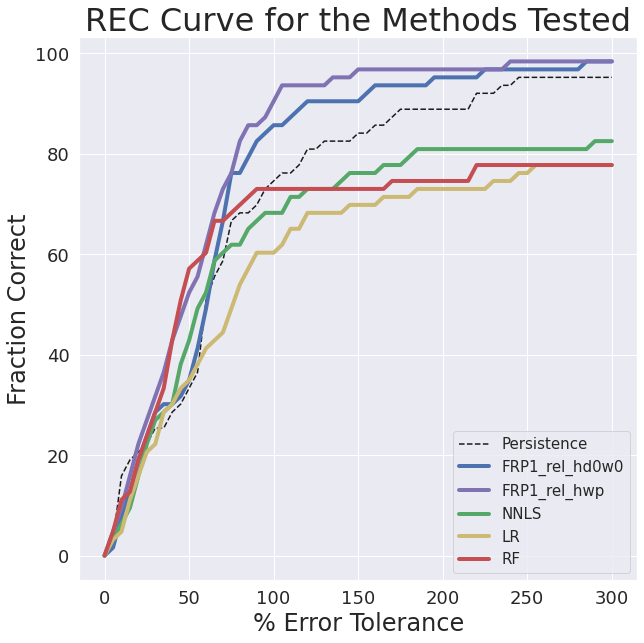

In [99]:
#this cell compares the ML predictions with the new derived indices
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Yesterday_FRP'],secondary_y=True,
                            figsize=(20,6),style='k--',ax=ax )
labels_test.plot(x='day', y=['FRP1_rel_hd0w0','FRP1_rel_hwp','Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['b-','m-','g-','y-','r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()


#now do the scores
print('R2 scores:')
print('Persistence score is: ' + str(r2_score(labels_test['Mean_FRP'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_hd0w0'])))
print('FRP1_rel_hwp score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_hwp'])))
print('Linear regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['Linreg_FRP'])))
print('Non-Negative Linear regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['NNLS_FRP'])))
print('Random Forest regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['RF_FRP']))+
      ' And the OOB score is: ' + str(1-rf.oob_score_))
print()
print('RMSE: ')
print('Persistence score is: ' + str(RMSE(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(RMSE(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(RMSE(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(RMSE(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(RMSE(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(RMSE(labels_test['RF_FRP'], labels_test['Mean_FRP'])))

print()
print('mean absolute error:')
print('Persistence score is: ' + str(MAD(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(MAD(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(MAD(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(MAD(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(MAD(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(MAD(labels_test['RF_FRP'], labels_test['Mean_FRP'])))


print()
print('mean absolute percent error:')
print('Persistence score is: ' + str(mean_percent_error(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(mean_percent_error(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mean_percent_error(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(mean_percent_error(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(mean_percent_error(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(mean_percent_error(labels_test['RF_FRP'], labels_test['Mean_FRP'])))


print()
print('Median Relative Absolute Error Compared to Persistence')
#mdrae(y_test, y_pred, bnchmrk)
print('FRP1_rel_hd0w0 score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_hd0w0'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_hwp'],labels_test['Yesterday_FRP'])))
print('Linear regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['Linreg_FRP'],labels_test['Yesterday_FRP'])))
print('Non-Negative Linear regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['NNLS_FRP'],labels_test['Yesterday_FRP'])))
print('Random Forest regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['RF_FRP'],labels_test['Yesterday_FRP'])))


#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)
thresh_hdw, accuracies_hdw = REC(labels_test['FRP1_rel_hd0w0'].values, labels_test['Mean_FRP'].values)
thresh_hwp, accuracies_hwp = REC(labels_test['FRP1_rel_hwp'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresh_NNLS, accuracies_NNLS = REC(labels_test['NNLS_FRP'].values, labels_test['Mean_FRP'].values)
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)

print()
print('AUC')
#mdrae(y_test, y_pred, bnchmrk)
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('FRP1_rel_hd0w0 score is: ' + str(AUC(accuracies_hdw)))
print('FRP1_rel_hwp score is: ' + str(AUC(accuracies_hwp)))
print('Linear regression score is: ' + str(AUC(accuracies_LR)))
print('Non-Negative Linear regression score is: ' + str(AUC(accuracies_NNLS)))
print('Random Forest regression score is: ' + str(AUC(accuracies_RF)))



plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--')
plt.plot(thresh_hdw, accuracies_hdw,'b-',linewidth=4)
plt.plot(thresh_hwp, accuracies_hwp,'m-',linewidth=4)
plt.plot(thresh_LR, accuracies_LR,'g-',linewidth=4)
plt.plot(thresh_NNLS, accuracies_NNLS,'y-',linewidth=4)
plt.plot(thresh_RF, accuracies_RF,'r-',linewidth=4)

plt.legend(['Persistence', 'FRP1_rel_hd0w0','FRP1_rel_hwp','NNLS','LR','RF'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


# Features: HWP, HD1W0, Yesterday %cont, extreme fuel loading, and persistence

Created 2/28

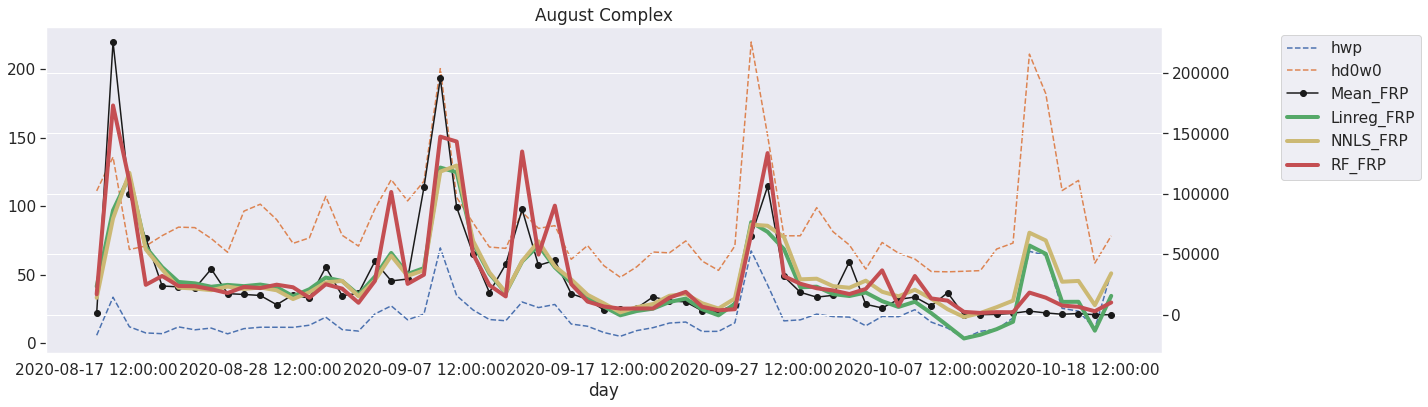

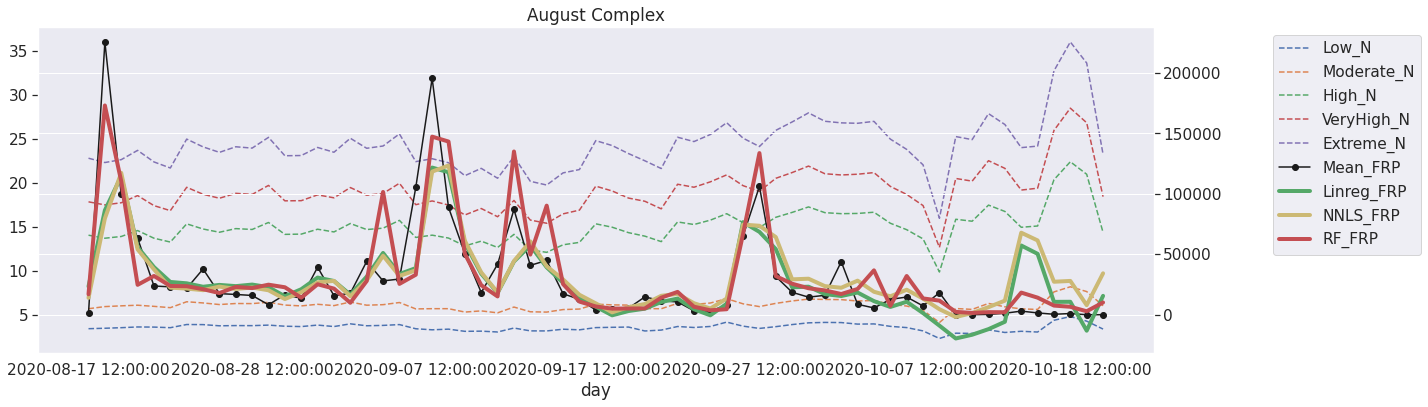

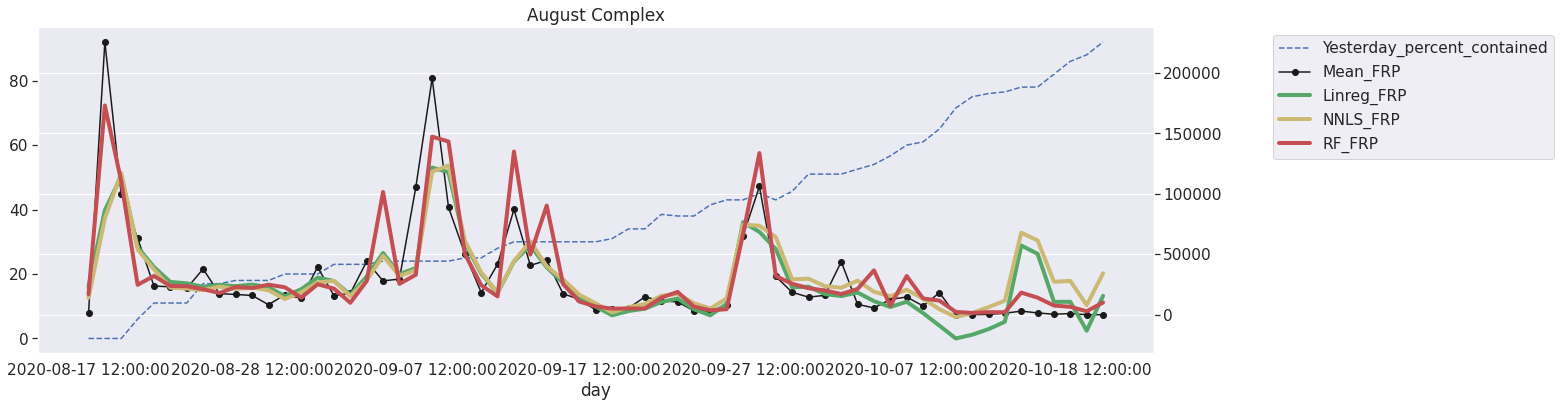

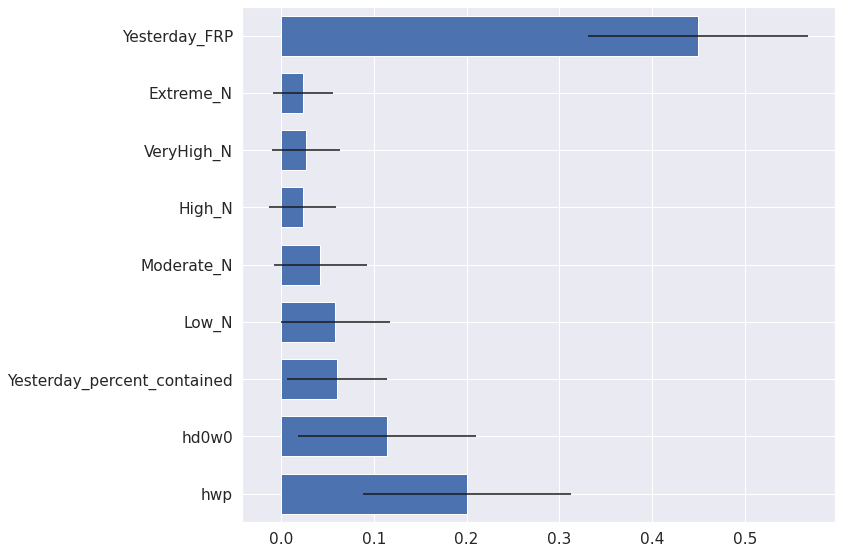

Feature: 0, Score: 9950.40202
Feature: 1, Score: 8852.35579
Feature: 2, Score: -8129.22486
Feature: 3, Score: 14256.43470
Feature: 4, Score: -16552.11312
Feature: 5, Score: 3355.84520
Feature: 6, Score: -686.77882
Feature: 7, Score: 4096.26616
Feature: 8, Score: 22268.33037


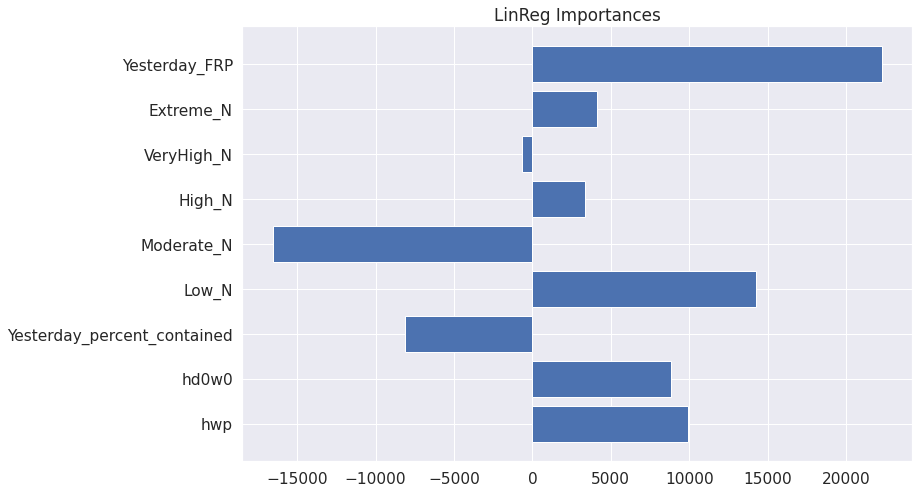

Feature: 0, Score: 8245.50016
Feature: 1, Score: 8809.16932
Feature: 2, Score: 0.00000
Feature: 3, Score: 3472.99838
Feature: 4, Score: 392.34294
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 24895.43854


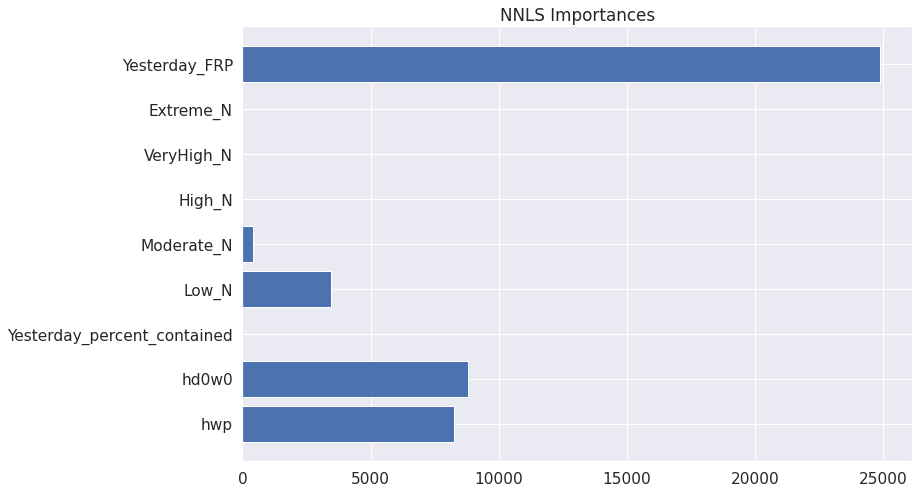

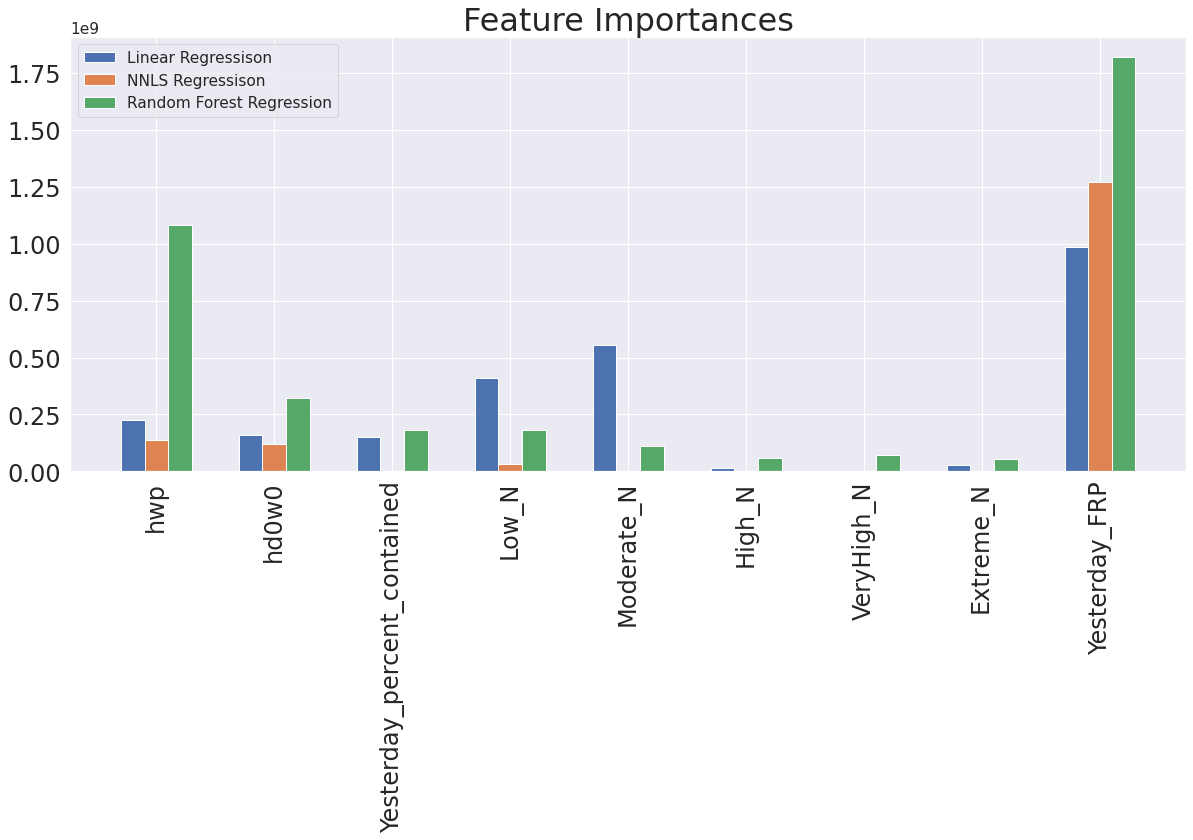

In [101]:
#this cell generates the ML predictions and evaluates them

#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','hd0w0','Yesterday_percent_contained','Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N','Yesterday_FRP']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
#linreg = Ridge()
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

nnls = make_pipeline(StandardScaler(), Ridge(solver='lbfgs',positive=True)) #scaling is necessary
#linreg = Ridge()
nnls.fit(features_train,labels_train)
nnls_frp_pred = nnls.predict(features_test)

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['NNLS_FRP'] = nnls_frp_pred
labels_test['RF_FRP'] = rf_frp_pred


#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Yesterday_percent_contained'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()


tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_, height=0.7,xerr = std)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(features_test.columns)
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.show()

# get importance
importance = linreg.named_steps['ridge'].coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=np.arange(len(training_variables)),labels=training_variables)
plt.title('LinReg Importances')
plt.show()

importance = nnls.named_steps['ridge'].coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=np.arange(len(training_variables)),labels=training_variables)
plt.title('NNLS Importances')
plt.show()

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_pos_lr = permutation_importance(nnls, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.2, label = 'Linear Regressison')
plt.bar(X_axis, importance_pos_lr, 0.2, label = 'NNLS Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.2, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

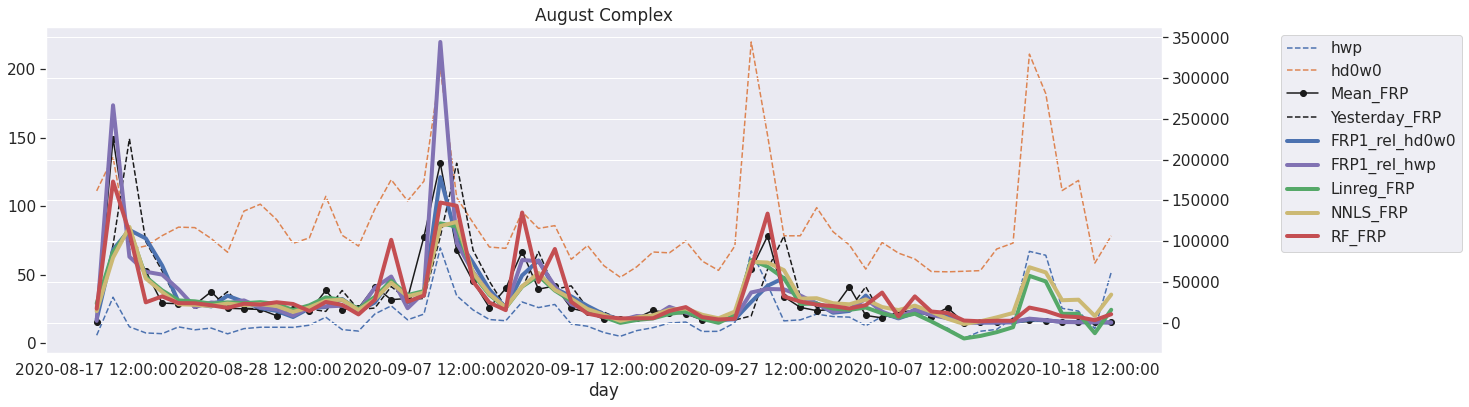

R2 scores:
Persistence score is: 0.23874435617129908
FRP1_rel_hd0w0 score is: 0.619983459770578
FRP1_rel_hwp score is: 0.6267629711513965
Linear regression score is: 0.5825149265085503
Non-Negative Linear regression score is: 0.5218996081723577
Random Forest regression score is: 0.7230476924031765 And the OOB score is: 0.6238977269310076

RMSE: 
Persistence score is: 36797.31335820134
FRP1_rel_hd0w0 score is: 25998.727872376545
FRP1_rel_hwp score is: 25765.77501419412
Linear regression score is: 27250.302317294485
Non-Negative Linear regression score is: 29161.536187624904
Random Forest regression score is: 22194.907658294866

mean absolute error:
Persistence score is: 20841.036228935347
FRP1_rel_hd0w0 score is: 14739.794074190957
FRP1_rel_hwp score is: 12980.941487103488
Linear regression score is: 16395.803966477633
Non-Negative Linear regression score is: 17555.650390355884
Random Forest regression score is: 13793.354294907247

mean absolute percent error:
Persistence score is: 101.

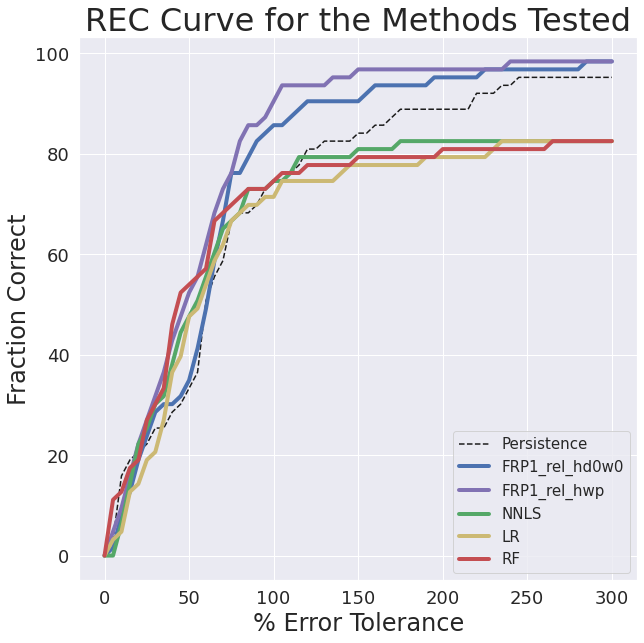

In [102]:
#this cell compares the ML predictions with the new derived indices
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Yesterday_FRP'],secondary_y=True,
                            figsize=(20,6),style='k--',ax=ax )
labels_test.plot(x='day', y=['FRP1_rel_hd0w0','FRP1_rel_hwp','Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['b-','m-','g-','y-','r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()


#now do the scores
print('R2 scores:')
print('Persistence score is: ' + str(r2_score(labels_test['Mean_FRP'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_hd0w0'])))
print('FRP1_rel_hwp score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_hwp'])))
print('Linear regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['Linreg_FRP'])))
print('Non-Negative Linear regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['NNLS_FRP'])))
print('Random Forest regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['RF_FRP']))+
      ' And the OOB score is: ' + str(1-rf.oob_score_))
print()
print('RMSE: ')
print('Persistence score is: ' + str(RMSE(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(RMSE(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(RMSE(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(RMSE(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(RMSE(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(RMSE(labels_test['RF_FRP'], labels_test['Mean_FRP'])))

print()
print('mean absolute error:')
print('Persistence score is: ' + str(MAD(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(MAD(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(MAD(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(MAD(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(MAD(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(MAD(labels_test['RF_FRP'], labels_test['Mean_FRP'])))


print()
print('mean absolute percent error:')
print('Persistence score is: ' + str(mean_percent_error(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(mean_percent_error(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mean_percent_error(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(mean_percent_error(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(mean_percent_error(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(mean_percent_error(labels_test['RF_FRP'], labels_test['Mean_FRP'])))


print()
print('Median Relative Absolute Error Compared to Persistence')
#mdrae(y_test, y_pred, bnchmrk)
print('FRP1_rel_hd0w0 score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_hd0w0'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_hwp'],labels_test['Yesterday_FRP'])))
print('Linear regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['Linreg_FRP'],labels_test['Yesterday_FRP'])))
print('Non-Negative Linear regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['NNLS_FRP'],labels_test['Yesterday_FRP'])))
print('Random Forest regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['RF_FRP'],labels_test['Yesterday_FRP'])))


#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)
thresh_hdw, accuracies_hdw = REC(labels_test['FRP1_rel_hd0w0'].values, labels_test['Mean_FRP'].values)
thresh_hwp, accuracies_hwp = REC(labels_test['FRP1_rel_hwp'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresh_NNLS, accuracies_NNLS = REC(labels_test['NNLS_FRP'].values, labels_test['Mean_FRP'].values)
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)

print()
print('AUC')
#mdrae(y_test, y_pred, bnchmrk)
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('FRP1_rel_hd0w0 score is: ' + str(AUC(accuracies_hdw)))
print('FRP1_rel_hwp score is: ' + str(AUC(accuracies_hwp)))
print('Linear regression score is: ' + str(AUC(accuracies_LR)))
print('Non-Negative Linear regression score is: ' + str(AUC(accuracies_NNLS)))
print('Random Forest regression score is: ' + str(AUC(accuracies_RF)))



plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--')
plt.plot(thresh_hdw, accuracies_hdw,'b-',linewidth=4)
plt.plot(thresh_hwp, accuracies_hwp,'m-',linewidth=4)
plt.plot(thresh_LR, accuracies_LR,'g-',linewidth=4)
plt.plot(thresh_NNLS, accuracies_NNLS,'y-',linewidth=4)
plt.plot(thresh_RF, accuracies_RF,'r-',linewidth=4)

plt.legend(['Persistence', 'FRP1_rel_hd0w0','FRP1_rel_hwp','NNLS','LR','RF'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


# Features: HWP, HD1W0,FWI/FFMC/DMC/DC, Blended_SM,PWS,Yesterday %cont, extreme fuel loading, and persistence

Created 3/1, to look at the feature importances mainly (didn't share any time series or eval metrics)

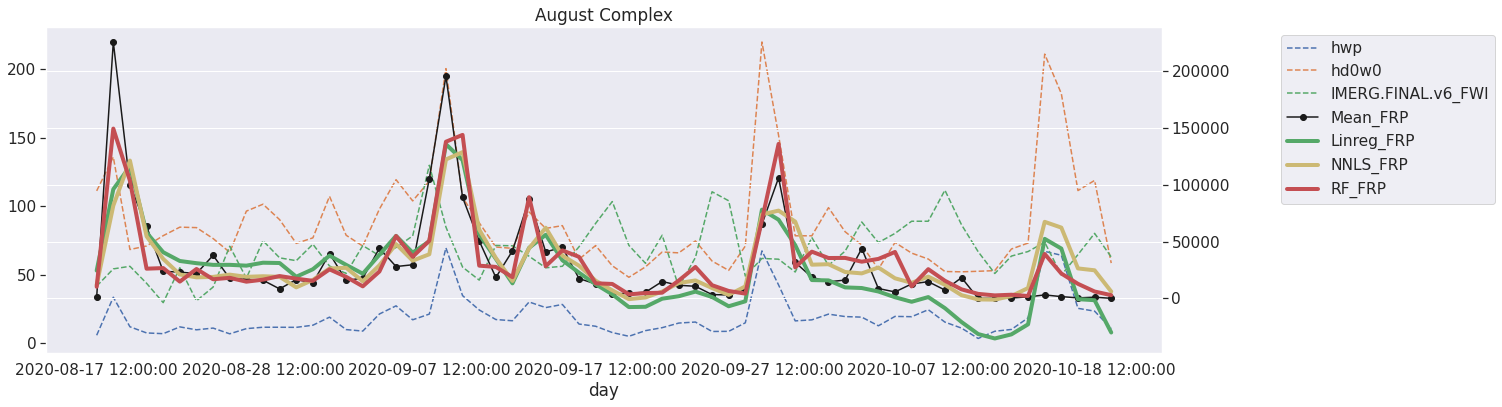

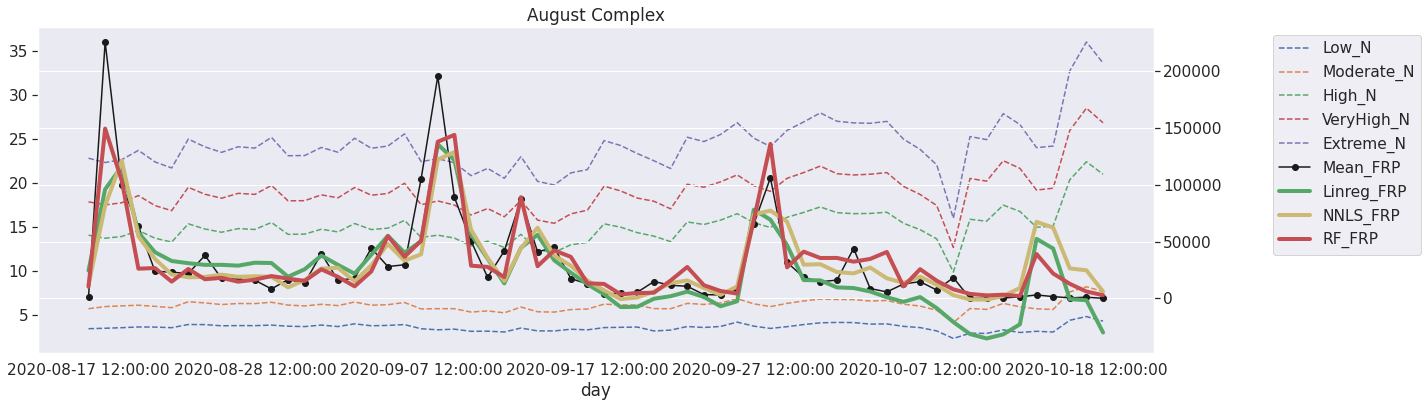

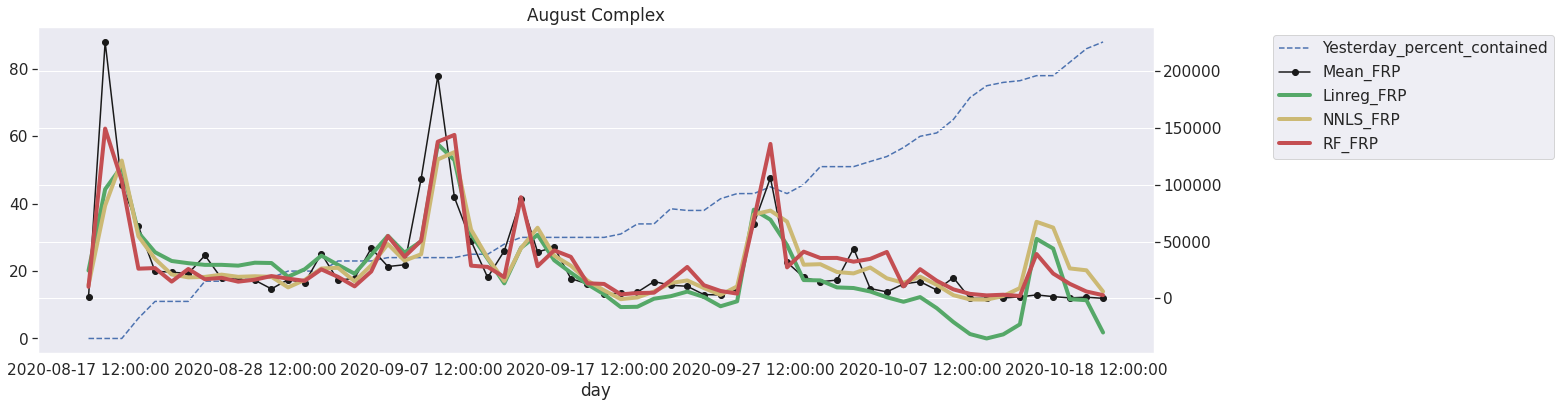

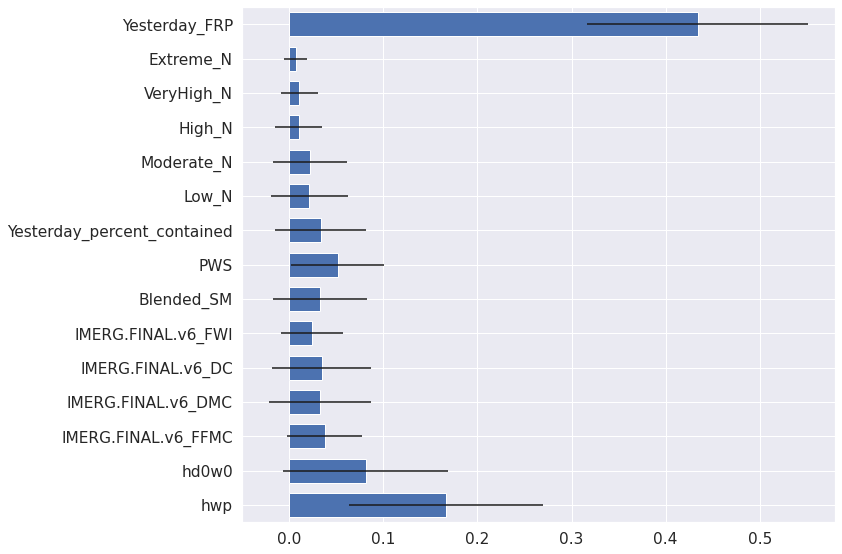

Feature: 0, Score: 9613.43892
Feature: 1, Score: 12742.81637
Feature: 2, Score: 69.40091
Feature: 3, Score: -10364.09357
Feature: 4, Score: 9806.55366
Feature: 5, Score: 1630.55823
Feature: 6, Score: 3127.38102
Feature: 7, Score: 2297.80906
Feature: 8, Score: -7590.61844
Feature: 9, Score: 13970.28842
Feature: 10, Score: -18292.73525
Feature: 11, Score: 4332.35881
Feature: 12, Score: 138.99940
Feature: 13, Score: 4983.81943
Feature: 14, Score: 22289.20185


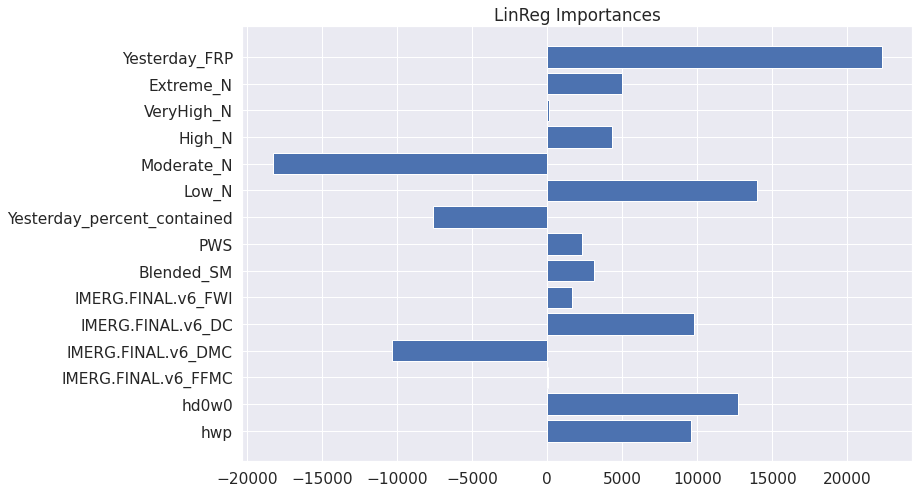

Feature: 0, Score: 7502.15000
Feature: 1, Score: 9931.38230
Feature: 2, Score: 2122.36330
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 1975.04417
Feature: 7, Score: 1734.95740
Feature: 8, Score: 0.00000
Feature: 9, Score: 2592.36512
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 26402.38309


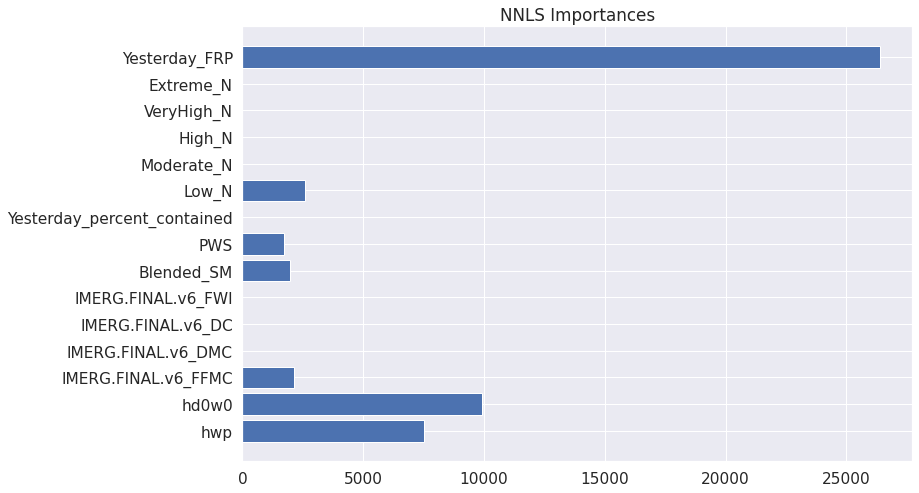

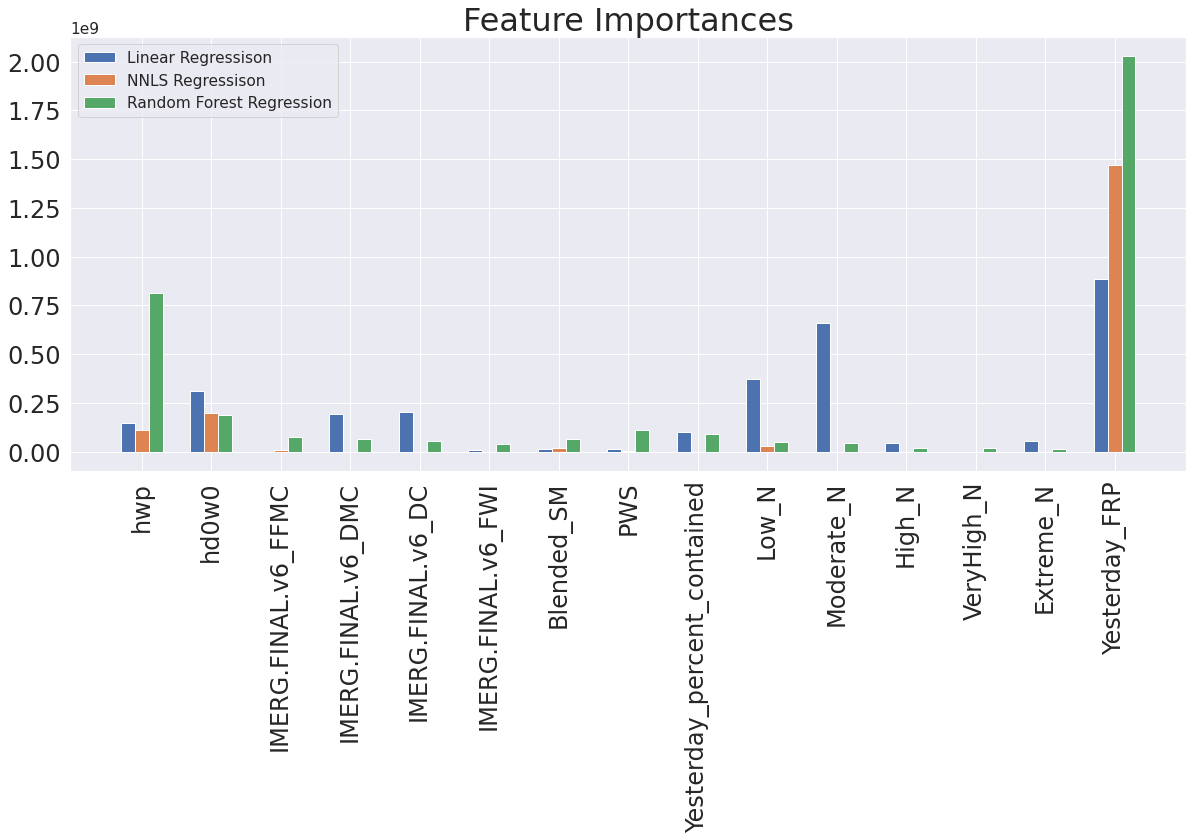

In [41]:
#this cell generates the ML predictions and evaluates them

#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','hd0w0','IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC','IMERG.FINAL.v6_FWI', 
                    'Blended_SM','PWS',
                    'Yesterday_percent_contained','Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N',
                    'Yesterday_FRP']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
#linreg = Ridge()
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

nnls = make_pipeline(StandardScaler(), Ridge(solver='lbfgs',positive=True)) #scaling is necessary
#linreg = Ridge()
nnls.fit(features_train,labels_train)
nnls_frp_pred = nnls.predict(features_test)

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['NNLS_FRP'] = nnls_frp_pred
labels_test['RF_FRP'] = rf_frp_pred


#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0','IMERG.FINAL.v6_FWI'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Yesterday_percent_contained'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()


tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_, height=0.7,xerr = std)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(features_test.columns)
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.show()

# get importance
importance = linreg.named_steps['ridge'].coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=np.arange(len(training_variables)),labels=training_variables)
plt.title('LinReg Importances')
plt.show()

importance = nnls.named_steps['ridge'].coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=np.arange(len(training_variables)),labels=training_variables)
plt.title('NNLS Importances')
plt.show()

# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_pos_lr = permutation_importance(nnls, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.2, label = 'Linear Regressison')
plt.bar(X_axis, importance_pos_lr, 0.2, label = 'NNLS Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.2, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

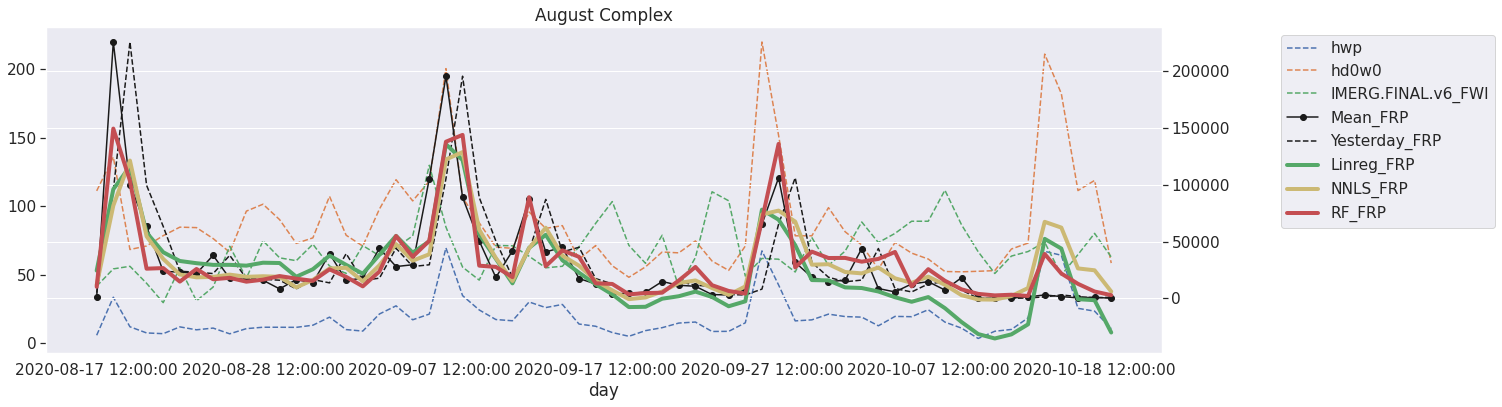

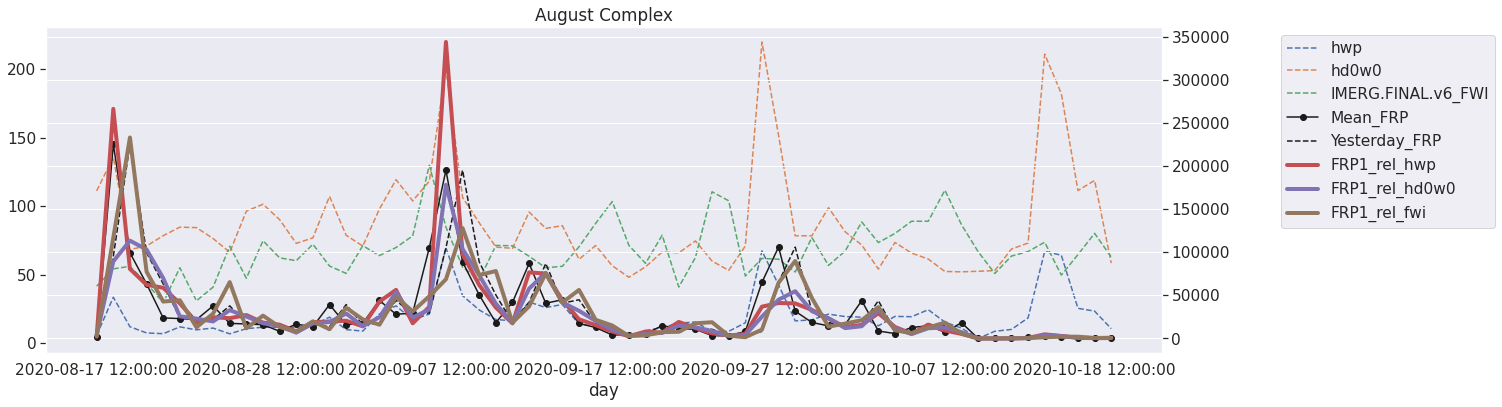

R2 scores:
Persistence score is: 0.23243226984468568
FRP1_rel_hd0w0 score is: 0.616832501735086
FRP1_rel_hwp score is: 0.6236681956376087
FRP1_rel_fwi score is: 0.29979097603687566
Linear regression score is: 0.5807825385774311
Non-Negative Linear regression score is: 0.5391049903319425
Random Forest regression score is: 0.7527216699024191 And the OOB score is: 0.5410891699916043

RMSE: 
Persistence score is: 37092.878127445416
FRP1_rel_hd0w0 score is: 26207.555268780245
FRP1_rel_hwp score is: 25972.7323424921
FRP1_rel_fwi score is: 35427.95059288301
Linear regression score is: 27412.702982272363
Non-Negative Linear regression score is: 28743.071918460624
Random Forest regression score is: 21053.54380334033

mean absolute error:
Persistence score is: 21176.24818318741
FRP1_rel_hd0w0 score is: 14976.576363650707
FRP1_rel_hwp score is: 13190.208972013672
FRP1_rel_fwi score is: 20981.312064000926
Linear regression score is: 18695.671826384
Non-Negative Linear regression score is: 16902.99

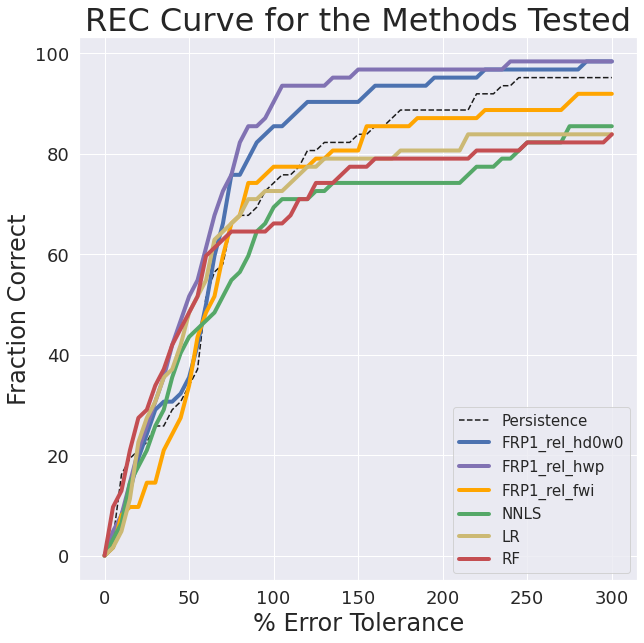

In [42]:
#this cell compares the ML predictions with the new derived indices
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0','IMERG.FINAL.v6_FWI'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Yesterday_FRP'],secondary_y=True,
                            figsize=(20,6),style='k--',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','NNLS_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-','y-','r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp','hd0w0','IMERG.FINAL.v6_FWI'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Yesterday_FRP'],secondary_y=True,
                            figsize=(20,6),style='k--',ax=ax )
labels_test.plot(x='day', y=['FRP1_rel_hwp','FRP1_rel_hd0w0','FRP1_rel_fwi'],secondary_y=True,
                            figsize=(20,6),style='-',linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex')
plt.show()


#now do the scores
print('R2 scores:')
print('Persistence score is: ' + str(r2_score(labels_test['Mean_FRP'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_hd0w0'])))
print('FRP1_rel_hwp score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_hwp'])))
print('FRP1_rel_fwi score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['FRP1_rel_fwi'])))
print('Linear regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['Linreg_FRP'])))
print('Non-Negative Linear regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['NNLS_FRP'])))
print('Random Forest regression score is: ' + str(r2_score(labels_test['Mean_FRP'], labels_test['RF_FRP']))+
      ' And the OOB score is: ' + str(1-rf.oob_score_))
print()
print('RMSE: ')
print('Persistence score is: ' + str(RMSE(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(RMSE(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(RMSE(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('FRP1_rel_fwi score is: ' + str(RMSE(labels_test['FRP1_rel_fwi'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(RMSE(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(RMSE(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(RMSE(labels_test['RF_FRP'], labels_test['Mean_FRP'])))

print()
print('mean absolute error:')
print('Persistence score is: ' + str(MAD(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(MAD(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(MAD(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('FRP1_rel_fwi score is: ' + str(MAD(labels_test['FRP1_rel_fwi'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(MAD(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(MAD(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(MAD(labels_test['RF_FRP'], labels_test['Mean_FRP'])))


print()
print('mean absolute percent error:')
print('Persistence score is: ' + str(mean_percent_error(labels_test['Yesterday_FRP'],labels_test['Mean_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(mean_percent_error(labels_test['FRP1_rel_hd0w0'], labels_test['Mean_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mean_percent_error(labels_test['FRP1_rel_hwp'], labels_test['Mean_FRP'])))
print('FRP1_rel_fwi score is: ' + str(mean_percent_error(labels_test['FRP1_rel_fwi'], labels_test['Mean_FRP'])))
print('Linear regression score is: ' + str(mean_percent_error(labels_test['Linreg_FRP'], labels_test['Mean_FRP'])))
print('Non-Negative Linear regression score is: ' + str(mean_percent_error(labels_test['NNLS_FRP'], labels_test['Mean_FRP'])))
print('Random Forest regression score is: ' + str(mean_percent_error(labels_test['RF_FRP'], labels_test['Mean_FRP'])))


print()
print('Median Relative Absolute Error Compared to Persistence')
#mdrae(y_test, y_pred, bnchmrk)
print('FRP1_rel_hd0w0 score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_hd0w0'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_hwp'],labels_test['Yesterday_FRP'])))
print('FRP1_rel_fwi score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['FRP1_rel_fwi'],labels_test['Yesterday_FRP'])))
print('Linear regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['Linreg_FRP'],labels_test['Yesterday_FRP'])))
print('Non-Negative Linear regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['NNLS_FRP'],labels_test['Yesterday_FRP'])))
print('Random Forest regression score is: ' + str(mdrae(labels_test['Mean_FRP'], labels_test['RF_FRP'],labels_test['Yesterday_FRP'])))


#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)
thresh_hdw, accuracies_hdw = REC(labels_test['FRP1_rel_hd0w0'].values, labels_test['Mean_FRP'].values)
thresh_hwp, accuracies_hwp = REC(labels_test['FRP1_rel_hwp'].values, labels_test['Mean_FRP'].values)
thresh_fwi, accuracies_fwi = REC(labels_test['FRP1_rel_fwi'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresh_NNLS, accuracies_NNLS = REC(labels_test['NNLS_FRP'].values, labels_test['Mean_FRP'].values)
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)

print()
print('AUC')
#mdrae(y_test, y_pred, bnchmrk)
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('FRP1_rel_hd0w0 score is: ' + str(AUC(accuracies_hdw)))
print('FRP1_rel_hwp score is: ' + str(AUC(accuracies_hwp)))
print('FRP1_rel_fwi score is: ' + str(AUC(accuracies_fwi)))
print('Linear regression score is: ' + str(AUC(accuracies_LR)))
print('Non-Negative Linear regression score is: ' + str(AUC(accuracies_NNLS)))
print('Random Forest regression score is: ' + str(AUC(accuracies_RF)))



plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--')
plt.plot(thresh_hdw, accuracies_hdw,'b-',linewidth=4)
plt.plot(thresh_hwp, accuracies_hwp,'m-',linewidth=4)
plt.plot(thresh_fwi, accuracies_fwi,linestyle='-',color='orange',linewidth=4)
plt.plot(thresh_LR, accuracies_LR,'g-',linewidth=4)
plt.plot(thresh_NNLS, accuracies_NNLS,'y-',linewidth=4)
plt.plot(thresh_RF, accuracies_RF,'r-',linewidth=4)

plt.legend(['Persistence', 'FRP1_rel_hd0w0','FRP1_rel_hwp','FRP1_rel_fwi','NNLS','LR','RF'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


# Features: HWP, HD1W0,FWI/FFMC/DMC/DC, Blended_SM,PWS,Yesterday %cont, extreme fuel loading, and persistence. With RECURSIVE Feature Elimination

Created 3/1

In [54]:
#this cell generates the ML predictions and evaluates them

#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','hd0w0','IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC','IMERG.FINAL.v6_FWI', 
                    'Blended_SM','PWS',
                    'Yesterday_percent_contained','Low_N','Moderate_N','High_N','VeryHigh_N','Extreme_N',
                    'Yesterday_FRP']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]


rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!

rfe = RFE(estimator=rf, n_features_to_select=5, step=1)
rfe.fit(features_train, labels_train)
ranking = rfe.ranking_
names = rfe.feature_names_in_

df_rank = pd.DataFrame({'Variable Names': names, 'Rank': ranking}).sort_values(by='Rank')
print(df_rank)

"""rf_frp_pred = rf.predict(features_test)
labels_test = data_test
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['NNLS_FRP'] = nnls_frp_pred
labels_test['RF_FRP'] = rf_frp_pred
"""

                 Variable Names  Rank
0                           hwp     1
1                         hd0w0     1
7                           PWS     1
10                   Moderate_N     1
14                Yesterday_FRP     1
2           IMERG.FINAL.v6_FFMC     2
3            IMERG.FINAL.v6_DMC     3
8   Yesterday_percent_contained     4
6                    Blended_SM     5
4             IMERG.FINAL.v6_DC     6
11                       High_N     7
5            IMERG.FINAL.v6_FWI     8
9                         Low_N     9
13                    Extreme_N    10
12                   VeryHigh_N    11


"rf_frp_pred = rf.predict(features_test)\n\nlabels_test = data_test\nlabels_test['Linreg_FRP'] = linreg_frp_pred\nlabels_test['NNLS_FRP'] = nnls_frp_pred\nlabels_test['RF_FRP'] = rf_frp_pred\n\n"

# Features: Persistence, HDW, PWS, extreme fuel loading, NCAR Moisture

Created 3/7
Only worry about Random Forest

In [10]:
inci_train = ['BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH','EAST TROUBLESOME']
inci_test = ['AUGUST COMPLEX']

#inci_train= ['AUGUST COMPLEX','HOLIDAY FARM','CREEK','CAMERON PEAK','PINE GULCH','EAST TROUBLESOME']
#inci_test = ['BOBCAT','DOLAN','LAKE']

data_train= combine_fires(inci_train) #train on not august complex (250 points, 79% of days)
data_train['FRP1_FMCG2D_rel_hd0w0'] = data_train['Yesterday_FRP']*(1-data_train['FMCG2D'])*data_train['hd0w0']/data_train['Yesterday_hd0w0']
data_train['FRP1_rel_hd0w0'] = data_train['Yesterday_FRP']*data_train['hd0w0']/data_train['Yesterday_hd0w0']
print(len(data_train))

data_test = combine_fires(inci_test) #test on august complex (69 points, 21% of days)
data_test['FRP1_FMCG2D_rel_hd0w0'] = data_test['Yesterday_FRP']*(1-data_test['FMCG2D'])*data_test['hd0w0']/data_test['Yesterday_hd0w0']
data_test['FRP1_rel_hd0w0'] = data_test['Yesterday_FRP']*data_test['hd0w0']/data_test['Yesterday_hd0w0']
print(len(data_test))


bobcat
dolan
holiday_farm
creek
lake
cameron_peak
pine_gulch
east_troublesome
263
august_complex
70


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


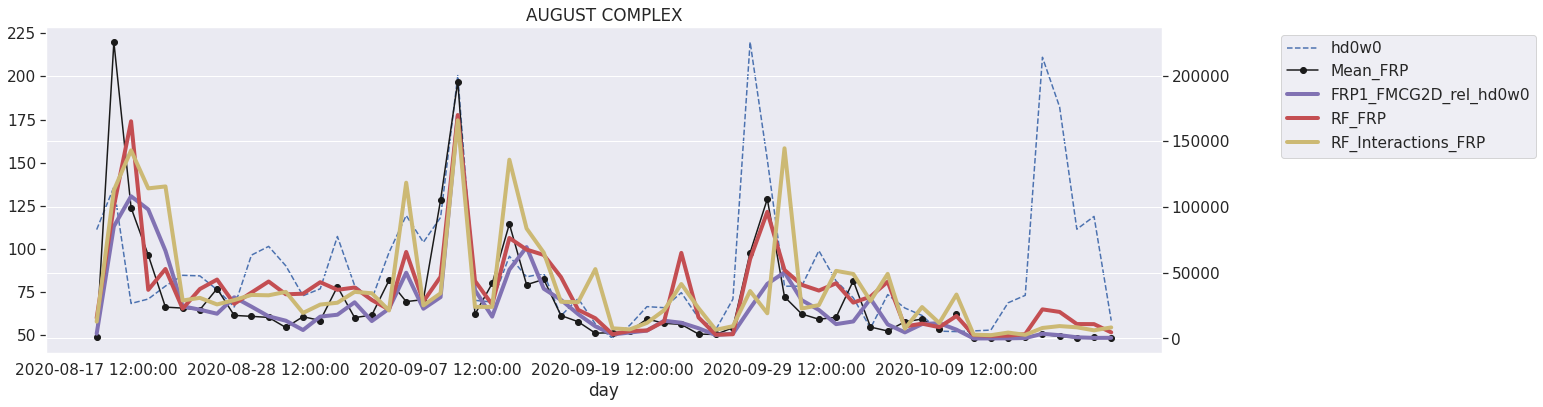

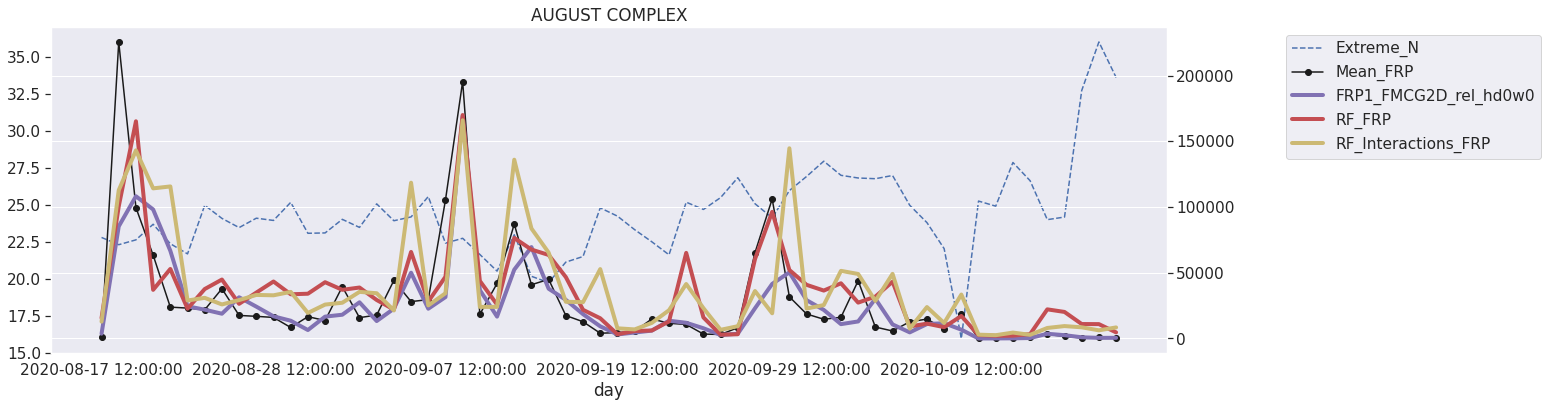

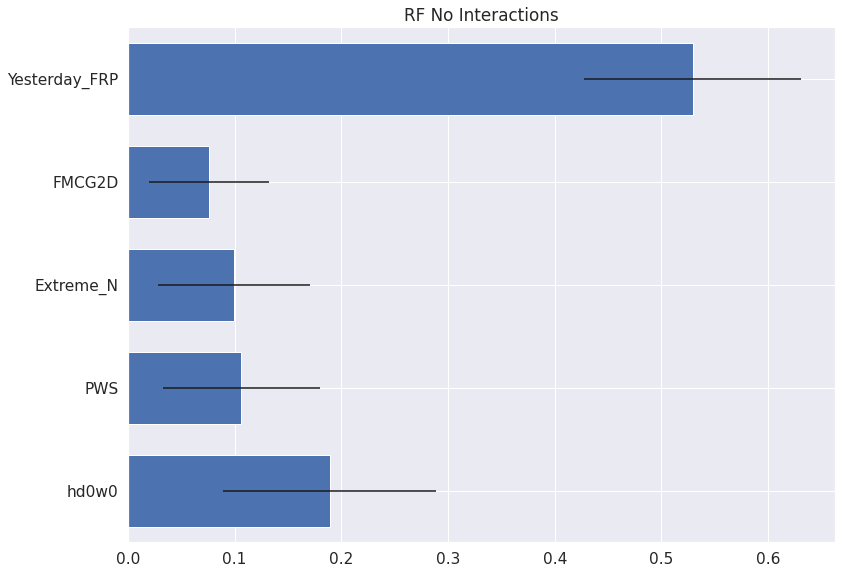

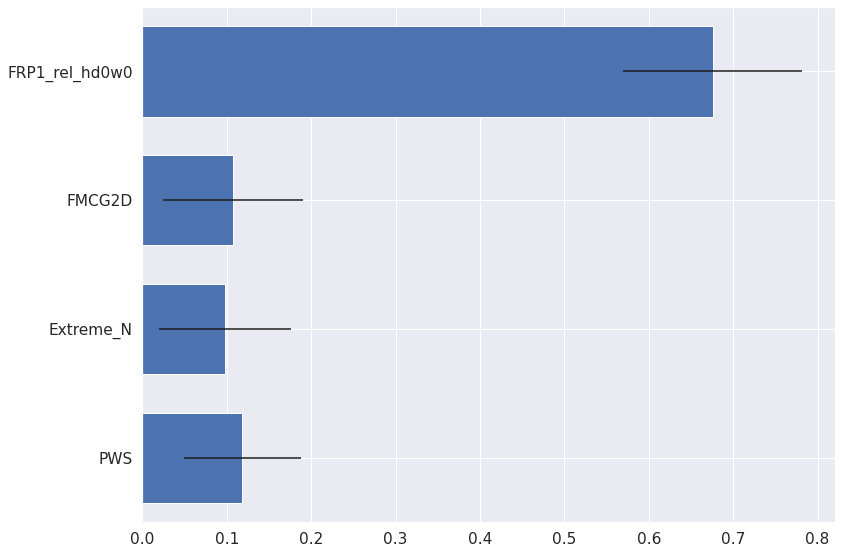

In [11]:
#this cell generates the ML predictions and evaluates them

#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hd0w0','PWS','Extreme_N','FMCG2D','Yesterday_FRP']
training_variables_interactions = ['PWS','Extreme_N','FMCG2D','FRP1_rel_hd0w0']

#do the train test split
#features_train = data_train.loc[:, training_variables]
#labels_train = data_train.loc[:,['Mean_FRP']]
#features_test = data_test.loc[:,training_variables]

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Mean_FRP']])
rf_frp = rf.predict(data_test.loc[:,training_variables])

rf_interactions = RandomForestRegressor(oob_score=True)
rf_interactions.fit(data_train.loc[:,training_variables_interactions],data_train.loc[:,['Mean_FRP']])
rf_interactions_frp = rf_interactions.predict(data_test.loc[:,training_variables_interactions])

labels_test = data_test
labels_test['RF_FRP'] = rf_frp
labels_test['RF_Interactions_FRP'] = rf_interactions_frp


for ii in range(len(inci_test)):
    labels_plot = labels_test[labels_test['name']==inci_test[ii]]
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='day', y=['hd0w0'],
                                figsize=(20,6),style='--',ax=ax )
    labels_plot.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='day', y=['FRP1_FMCG2D_rel_hd0w0','RF_FRP','RF_Interactions_FRP'],secondary_y=True,
                                figsize=(20,6),style=['m-','r-','y-'],linewidth=4,ax=ax)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()

    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='day', y=['Extreme_N'],
                                figsize=(20,6),style='--',ax=ax )
    labels_plot.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='day', y=['FRP1_FMCG2D_rel_hd0w0','RF_FRP','RF_Interactions_FRP'],secondary_y=True,
                                figsize=(20,6),style=['m-','r-','y-'],linewidth=4,ax=ax)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()

tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_, height=0.7,xerr = std)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(training_variables)
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.title('RF No Interactions')
plt.show()

tree_indices = np.arange(0, len(rf_interactions.feature_importances_)) + 0.5
importances = rf_interactions.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_interactions.estimators_], axis=0)
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf_interactions.feature_importances_, height=0.7,xerr = std)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(training_variables_interactions)
ax1.set_ylim((0, len(rf_interactions.feature_importances_)))
fig.tight_layout()
plt.show()

# OTHER

In [ ]:
plot_correlations(labels_test[['hwp','hd1w0','Yesterday_percent_contained','Extreme_N',
                               'Yesterday_FRP','Mean_FRP']], 'August Complex','pearson')

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hd1w0','Yesterday_percent_contained','Extreme_N']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test[['day','name','hwp','hd1w0','Mean_FRP','Yesterday_FRP','Yesterday_percent_contained','Extreme_N']]
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['RF_FRP'] = rf_frp_pred

print('Linear regression score is: ' + str(linreg.score(features_test, data_test['Mean_FRP'])))
print('Random forest regression score is: ' + str(rf.score(features_test, data_test['Mean_FRP'])) + 
       ' And the OOB score is: '+ str(1-rf.oob_score_))
print('Persistence score is: '+  str(r2_score(labels_test['Yesterday_FRP'], labels_test['Mean_FRP'])))

print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hd1w0'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-', 'r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Extreme_N'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-', 'r-'],linewidth=4,ax=ax)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(features_test.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.show()

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','Yesterday_percent_contained','Extreme_N']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test[['day','name','hwp','hd1w0','Mean_FRP','Yesterday_FRP','Yesterday_percent_contained','Extreme_N']]
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['RF_FRP'] = rf_frp_pred

print('Linear regression score is: ' + str(linreg.score(features_test, data_test['Mean_FRP'])))
print('Random forest regression score is: ' + str(rf.score(features_test, data_test['Mean_FRP'])) + 
       ' And the OOB score is: '+ str(1-rf.oob_score_))
print('Persistence score is: '+  str(r2_score(labels_test['Yesterday_FRP'], labels_test['Mean_FRP'])))

print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hwp'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-', 'r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Extreme_N'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-', 'r-'],linewidth=4,ax=ax)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(features_test.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.show()

In [ ]:
#drop the rows with nans
data_train = data_train.dropna(axis=0,how='any')
data_test = data_test.dropna(axis=0,how='any')

training_variables=['hwp','hd1w0','Yesterday_percent_contained']

#do the train test split
features_train = data_train.loc[:, training_variables]
labels_train = data_train.loc[:,['Mean_FRP']]
features_test = data_test.loc[:,training_variables]

linreg = make_pipeline(StandardScaler(), Ridge()) #scaling is necessary
linreg.fit(features_train,labels_train)
linreg_frp_pred = linreg.predict(features_test)

rf = RandomForestRegressor(oob_score=True) #scaling is not necessary!
rf.fit(features_train, labels_train)
rf_frp_pred = rf.predict(features_test)

labels_test = data_test[['day','name','hwp','hd1w0','Mean_FRP','Yesterday_FRP','Yesterday_percent_contained','Extreme_N']]
labels_test['Linreg_FRP'] = linreg_frp_pred
labels_test['RF_FRP'] = rf_frp_pred

print('Linear regression score is: ' + str(linreg.score(features_test, data_test['Mean_FRP'])))
print('Random forest regression score is: ' + str(rf.score(features_test, data_test['Mean_FRP'])) + 
       ' And the OOB score is: '+ str(1-rf.oob_score_))
print('Persistence score is: '+  str(r2_score(labels_test['Yesterday_FRP'], labels_test['Mean_FRP'])))

print('RMSE_LR=' + str(RMSE(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
      'RMSE_RF=' + str(RMSE(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'RMSE_persistence=' + str(RMSE(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))

print('MAD_LR=' + str(MAD(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values))+ 'vs '
      'MAD_RF=' + str(MAD(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values))+ ' vs '
     'MAD_persistence=' + str(MAD(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)))


fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['hd1w0','hwp'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-', 'r-'],linewidth=4,ax=ax )

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

fig, ax = plt.subplots(figsize=(20,15)) 
labels_test.plot(x='day', y=['Extreme_N'],
                            figsize=(20,6),style='--',ax=ax )
labels_test.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
labels_test.plot(x='day', y=['Linreg_FRP','RF_FRP'],secondary_y=True,
                            figsize=(20,6),style=['g-', 'r-'],linewidth=4,ax=ax)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('August Complex')
plt.show()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(features_test.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
fig.tight_layout()
plt.show()

In [ ]:
"""# perform permutation importance
importance_lr = permutation_importance(linreg, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean
importance_rf = permutation_importance(rf, features_train, labels_train, scoring='neg_mean_squared_error').importances_mean


plt.figure(figsize=(20,8))
#plt.bar([x for x in range(len(importance))], importance)
X_axis = np.arange(len(importance_lr)) 
plt.bar(X_axis - 0.2, importance_lr, 0.4, label = 'Linear Regressison')
plt.bar(X_axis + 0.2, importance_rf, 0.4, label = 'Random Forest Regression')
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance_lr))], labels = features_train, fontsize=24, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()


#REC CURVES
thresh_RF, accuracies_RF = REC(labels_test['RF_FRP'].values, labels_test['Mean_FRP'].values)
thresh_LR, accuracies_LR = REC(labels_test['Linreg_FRP'].values, labels_test['Mean_FRP'].values)
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['Mean_FRP'].values)
plt.figure(figsize=(10,10))
plt.plot(thresh_LR, accuracies_LR)
plt.plot(thresh_RF, accuracies_RF)
plt.plot(thresholds_persistence, accuracy_persistence)
plt.legend(['Linear Regression', 'Random Forest Regression','Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

#scatter plots
low = 1
high = 1e6
plot_log(labels_test['Mean_FRP'].values, labels_test['RF_FRP'].values, 'Random Forest Regression', low, high)
plot_log(labels_test['Mean_FRP'].values, labels_test['Linreg_FRP'].values, 'Linear Regression', low, high)"""